# Lab -6 Clustering Example - Customer Grouping

We are grouping a dataset with each unique customer has already been given the recency, frequency, and monetary values.

To add PySpark to sys.path for running the code on the Jupyter IDE we are Using the package findspark

In [1]:
import findspark
findspark.find()
findspark.init()

To perform any task on spark you need start a spark session, here we are starting a session for our logistic regression

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Clustering App").getOrCreate()

22/10/11 08:08:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


To start, we are loading the customer dataset


The features are

Recency: How recently customers made their purchase.

Frequency: For simplicity, we’ll count the number of times each customer made a purchase.

Monetary: The total amount of money they spent

In [3]:
cust = spark.read.csv('retail_loyalty_rfm.csv',header= True)
cust.printSchema()
cust.show()

root
 |-- CustomerID: string (nullable = true)
 |-- Recency: string (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- Monetary: string (nullable = true)
 |-- R_Score: string (nullable = true)
 |-- F_Score: string (nullable = true)
 |-- M_Score: string (nullable = true)
 |-- RFM_Score: string (nullable = true)
 |-- RFM_ScoreGroup: string (nullable = true)
 |-- Loyalty: string (nullable = true)

+----------+-------+---------+--------+-------+-------+-------+---------+--------------+--------+
|CustomerID|Recency|Frequency|Monetary|R_Score|F_Score|M_Score|RFM_Score|RFM_ScoreGroup| Loyalty|
+----------+-------+---------+--------+-------+-------+-------+---------+--------------+--------+
|     16678|      3|      163|  3111.0|      1|      1|      1|        3|           111|Platinum|
|     17735|      3|      690| 13207.0|      1|      1|      1|        3|           111|Platinum|
|     17139|     16|      478| 10750.0|      1|      1|      1|        3|           111|Platinum|
|

# Changing the column datatype

We need to change column datatype to float from the initial string datatype

In [4]:
from pyspark.sql.functions import col
cust1 = cust.select(*(col(c).cast('float').alias(c) for c in cust.columns))
cust1.printSchema()

root
 |-- CustomerID: float (nullable = true)
 |-- Recency: float (nullable = true)
 |-- Frequency: float (nullable = true)
 |-- Monetary: float (nullable = true)
 |-- R_Score: float (nullable = true)
 |-- F_Score: float (nullable = true)
 |-- M_Score: float (nullable = true)
 |-- RFM_Score: float (nullable = true)
 |-- RFM_ScoreGroup: float (nullable = true)
 |-- Loyalty: float (nullable = true)



# Dropping unwanted columns

We need to drop unwanted columns from the dataset. To have this insight in a complex problem. we have to formulate the hypothesis and evaluation of the hypothesis should be done.

In [5]:
colm = ['R_Score','F_Score', 'M_Score','RFM_Score','RFM_ScoreGroup','Loyalty']
cust2 = cust1.select([column for column in cust1.columns if column not in colm])
cust2.printSchema()

root
 |-- CustomerID: float (nullable = true)
 |-- Recency: float (nullable = true)
 |-- Frequency: float (nullable = true)
 |-- Monetary: float (nullable = true)



# Taking the count of the null and missing values

In [6]:
from pyspark.sql.functions import col, count, isnan, when
cust2.select([count(when(col(c).isNull(), c)).alias(c) for c in cust2.columns]).show()

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|         0|      0|        0|       0|
+----------+-------+---------+--------+



# Visualizing the data

To have an insight about the dataset we use the python library seaborn. The plots indicate the histogram of each features of dataset 

<AxesSubplot: xlabel='Monetary', ylabel='Count'>

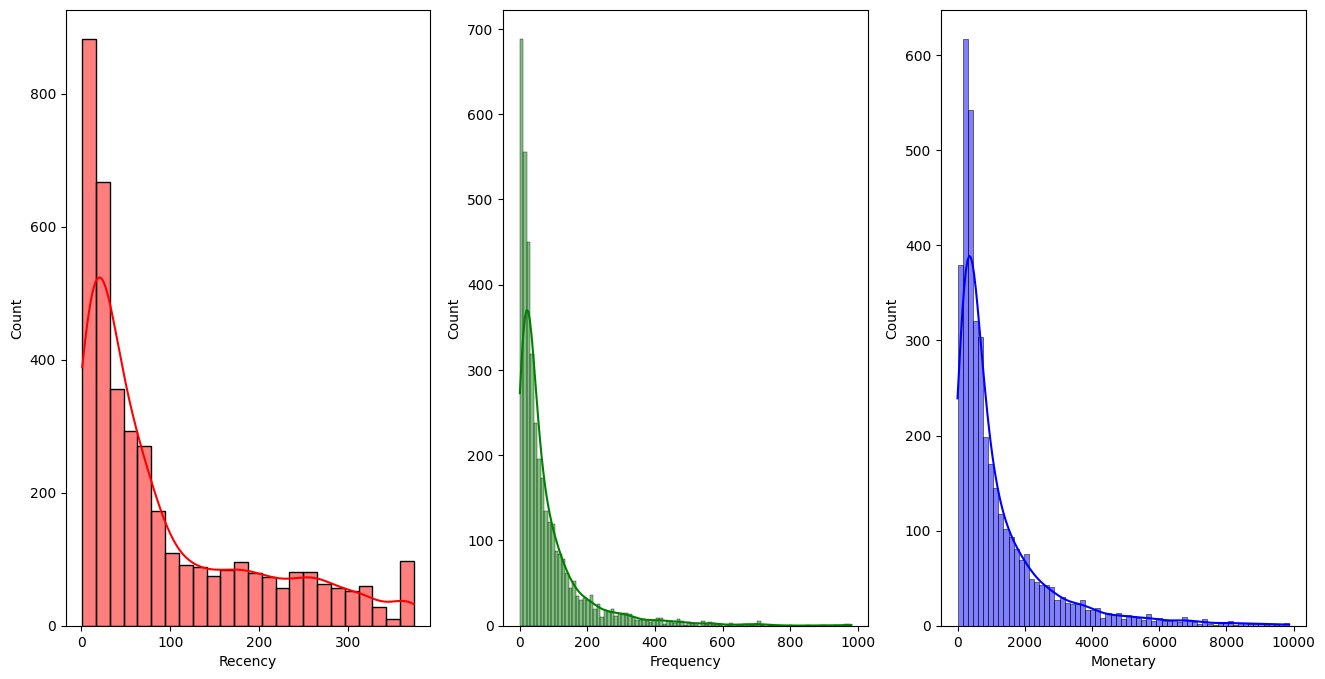

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
cust_df = cust2.toPandas()

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(cust_df['Recency'], color ='red', kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(cust_df.query('Frequency < 1000')['Frequency'], color ='green', kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(cust_df.query('Monetary < 10000')['Monetary'], color ='blue', kde=True, ax=ax[2])

The histogram figures show how the recency, frequency and monetary values are distributed in the given dataset. Most of the datapoints are distributed in the initial values of the graph. If any value is not significant we can remove it as an outlier.  

# Remove zero and negative numbers

For smooth working of algorithm, lets get rid of negative and zeros


In [11]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

rfm_data = (
    cust2.withColumn("Monetary", 
        F.when(F.col("Monetary") <= 0, 1)
         .otherwise(F.col("Monetary")))
)


# Vectorization and Scaler

Because of their skewed behavior and different scales and ranges, the three features (recency, frequency, and monetary) must be standardized, so that machine learning algorithms can identify the trends between them.


In [12]:
# Identifying feature columns
features = rfm_data.columns[1:]
# vectorize all the features
assembler = VectorAssembler(
    inputCols=features, 
    outputCol="rfm_features")
assembled_data = assembler.transform(rfm_data)
assembled_data = assembled_data.select(
    'CustomerID', 'rfm_features')
# Standardization
scaler = StandardScaler(
inputCol='rfm_features',
outputCol='features')
data_scale = scaler.fit(assembled_data)
scaled_data = data_scale.transform(assembled_data)


### Applying K-Means Clustering

Next, we're going to run k-means on the entire dataset one final time with the cluster number 'k' equal to 3 and create a column named 'prediction' for each customer's predicted cluster number.

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
k_means = KMeans(featuresCol='features', k=3)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

result = predictions.select('CustomerID', 'prediction')
result.show()


# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

22/10/11 08:16:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/11 08:16:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+----------+----------+
|CustomerID|prediction|
+----------+----------+
|   16678.0|         0|
|   17735.0|         0|
|   17139.0|         0|
|   13408.0|         0|
|   17389.0|         0|
|   14659.0|         0|
|   17738.0|         0|
|   15953.0|         0|
|   13418.0|         0|
|   16327.0|         0|
|   14032.0|         0|
|   14031.0|         0|
|   15465.0|         0|
|   16326.0|         0|
|   13426.0|         0|
|   14030.0|         0|
|   14961.0|         0|
|   14049.0|         0|
|   16790.0|         0|
|   14051.0|         0|
+----------+----------+
only showing top 20 rows

Silhouette with squared euclidean distance = 0.7369341912601257


In order to inspect the results with charts, let's join the prediction with the starting dataset.

In [14]:
rfm_score = spark.read.csv('retail_loyalty_rfm.csv', inferSchema=True, header=True)
rfm_score = rfm_score.select("CustomerID", "Recency", "Frequency", "Monetary", "RFM_Score", "RFM_ScoreGroup", "Loyalty")
combined_result = result.join(rfm_score, on='CustomerID', how='inner')

In [19]:
combined_result_df = combined_result.toPandas()
combined_result_df.to_csv('combined_result_k4.csv', index=False)
combined_result_df.head(5)

,CustomerID,prediction,Recency,Frequency,Monetary,RFM_Score,RFM_ScoreGroup,Loyalty
0,16678.0,0,3,163,3111.0,3,111,Platinum
1,17735.0,0,3,690,13207.0,3,111,Platinum
2,17139.0,0,16,478,10750.0,3,111,Platinum
3,13408.0,0,2,478,28127.0,3,111,Platinum
4,17389.0,0,1,213,31852.0,3,111,Platinum


# Visualizing the Results

We are visualizing the clusters, and the population in each clusters

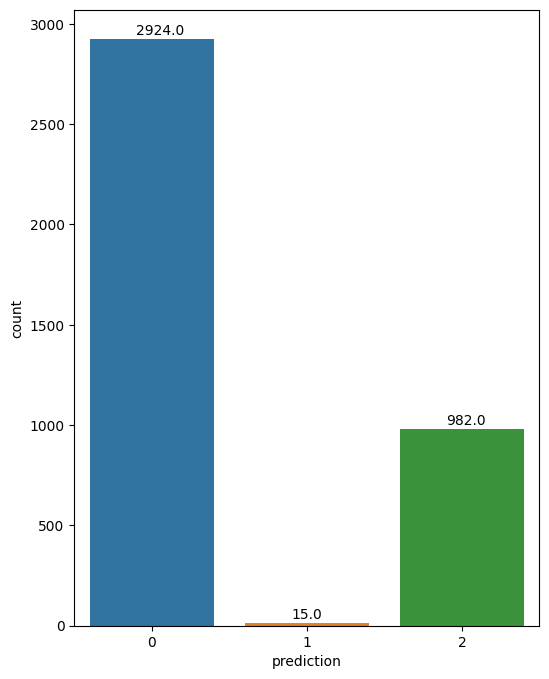

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=combined_result_df)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

We plot the recency, frequency, and monetary values of each cluster in a box plot, in order to better understand the prediction result.

<AxesSubplot: xlabel='prediction', ylabel='Monetary'>

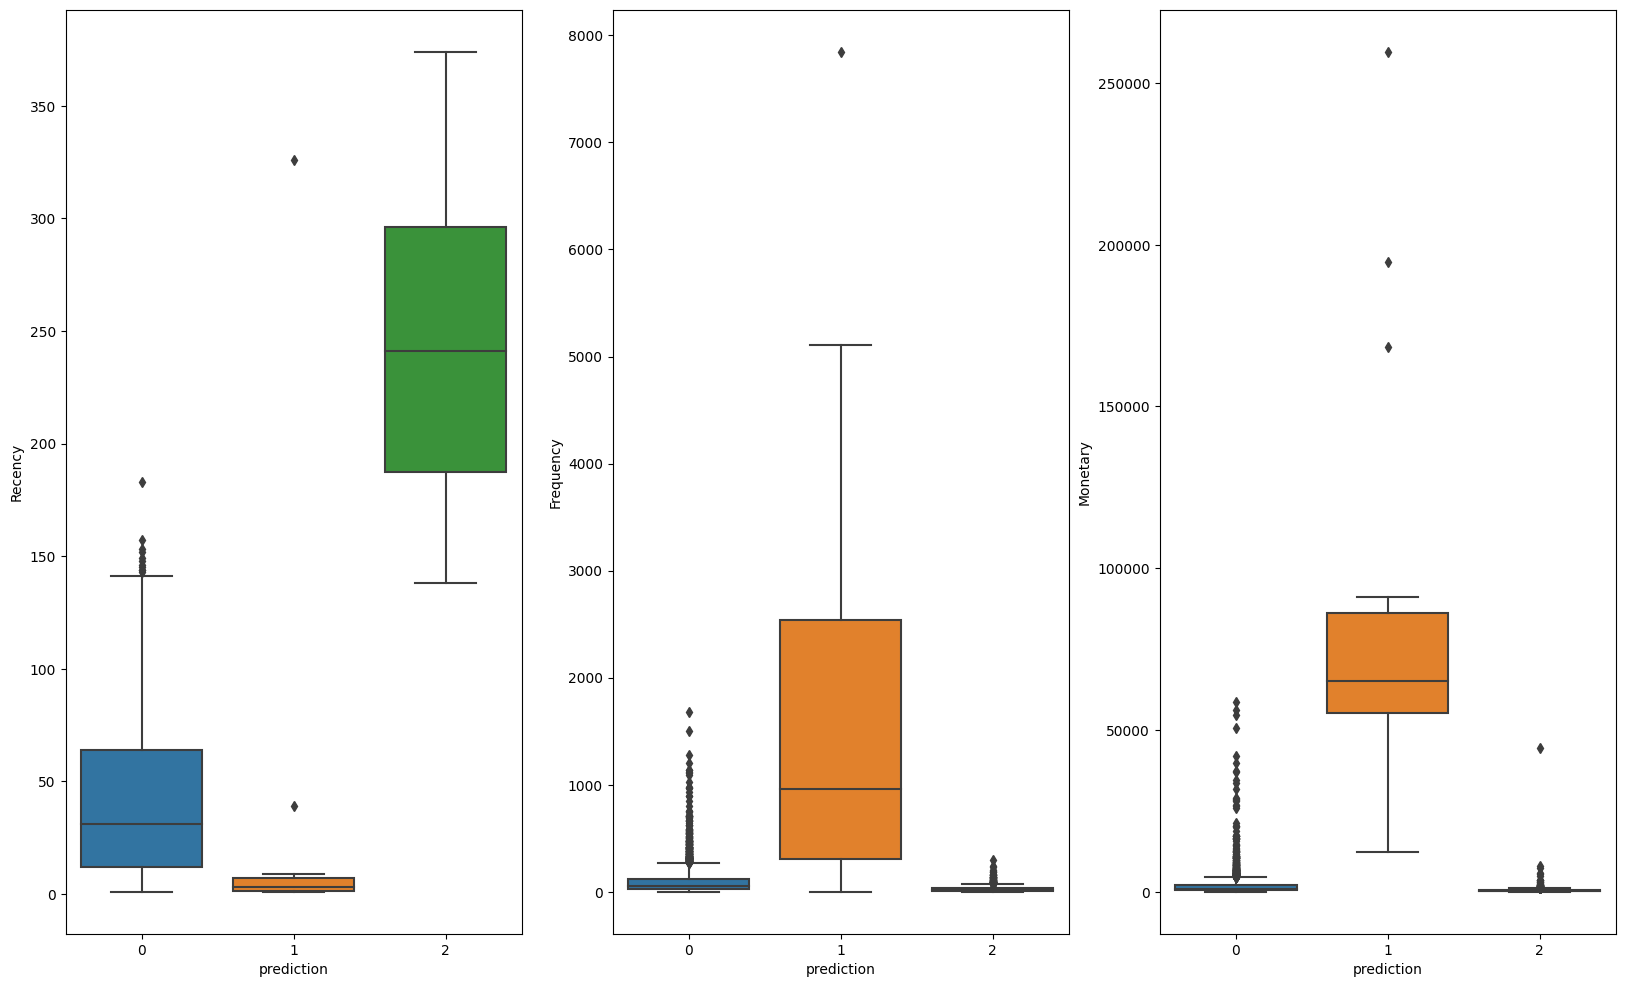

In [21]:
analysis_df = combined_result.toPandas()
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='Recency', data=analysis_df, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=analysis_df, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=analysis_df, ax=ax[2])

The boxplots of cluster values corresponds to each feature is shown. Using these boxplots we can identify the possible outliers corresponds to each feature.

# Visualizing Clusters
Visualizing the clusters by combining two features as a 2D plot will give a clear view about the grouping strategies of datapoints. 

<AxesSubplot: xlabel='Monetary', ylabel='Frequency'>

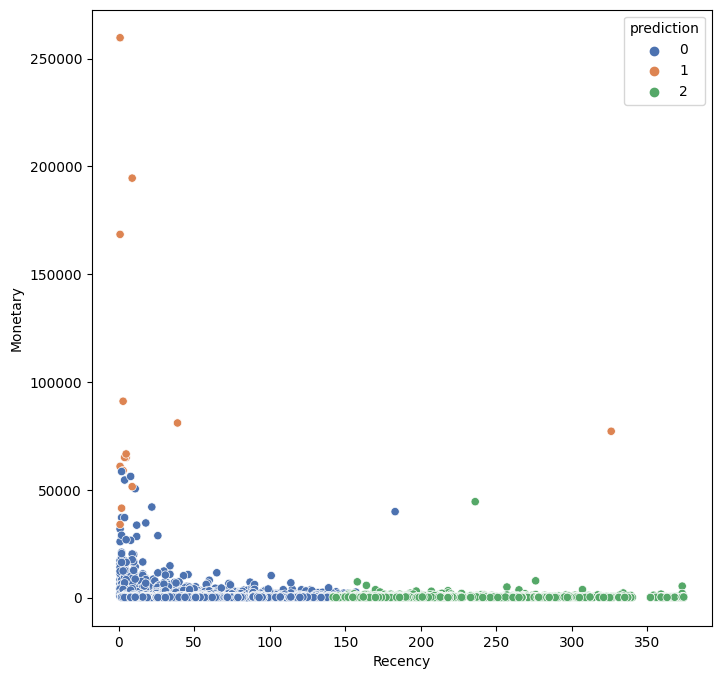

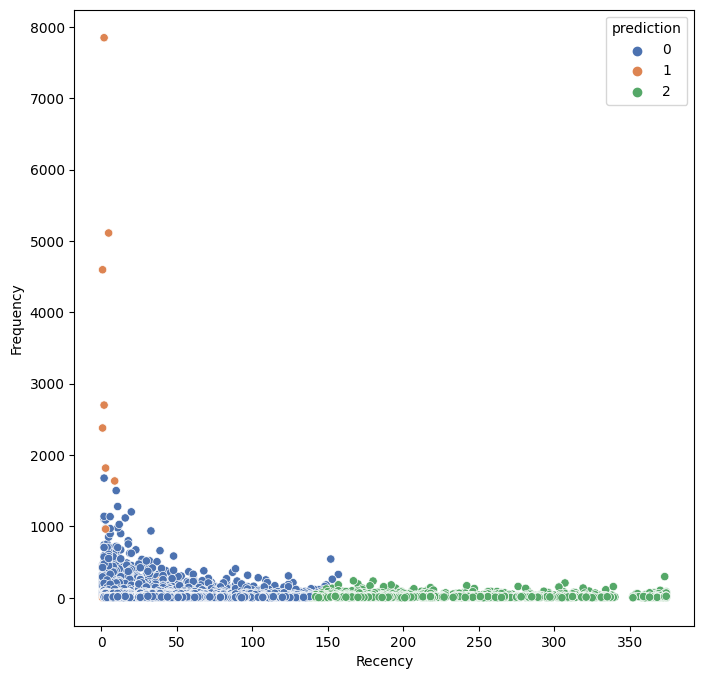

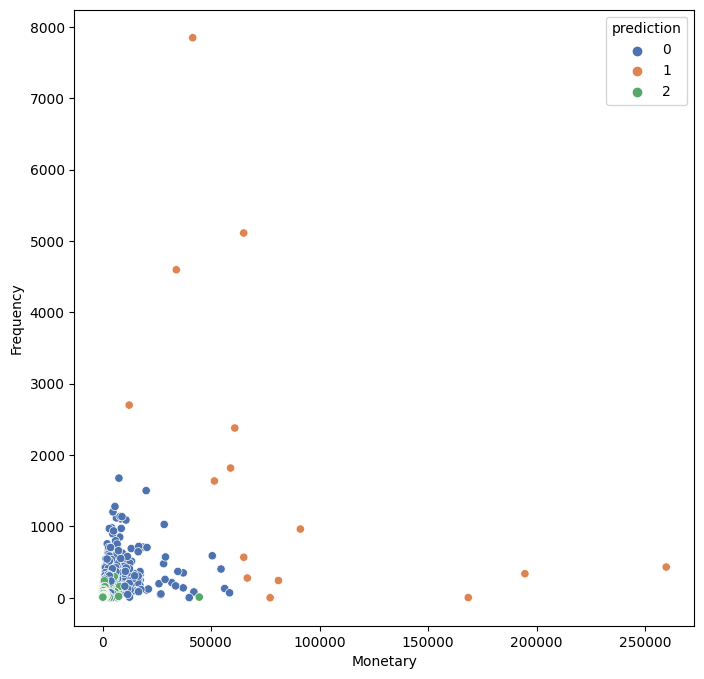

In [22]:
selected_result_df = combined_result_df#.query('Monetary < 100000').query('Frequency < 3000')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# 3D Visualization of clustering

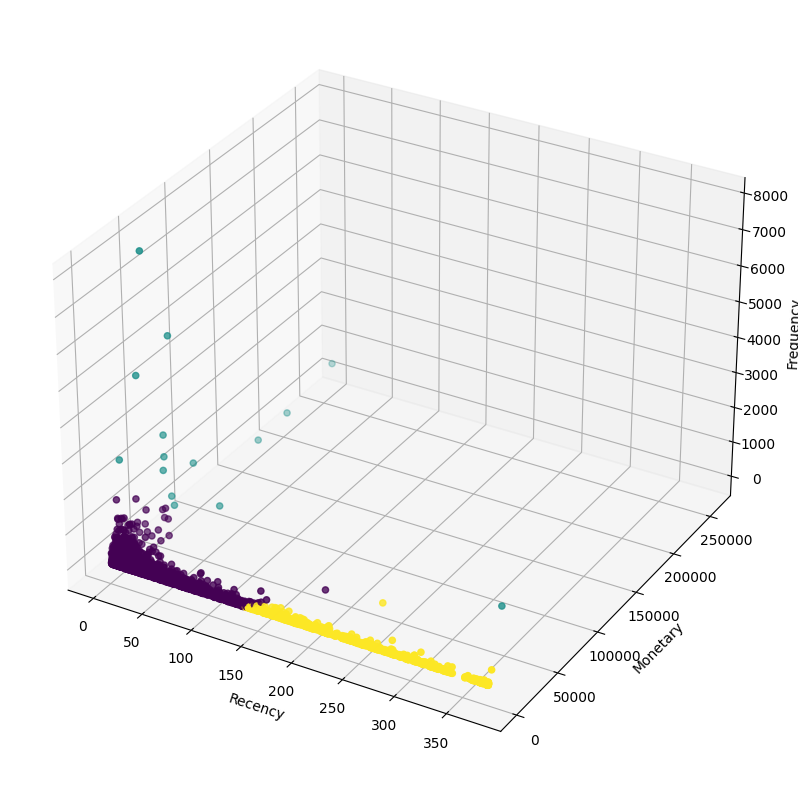

In [31]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
threedee = plt.figure(figsize=(12,10))
ax = plt.axes(projection ="3d")
ax.scatter3D(selected_result_df.Recency, selected_result_df.Monetary, selected_result_df.Frequency, c=selected_result_df.prediction)
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')
plt.show()

3D Visualization can give a good insight about how datagrouping is done corresponds to each feature in a single plot

# Applying Bisecting KMeans Clustering

Next, we're going to run k-means on the entire dataset one final time with the cluster number 'k' equal to 4 and create a column named 'prediction' for each customer's predicted cluster number.

In [32]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3)
model = bkm.fit(scaled_data)

# Make predictions
predictions = model.transform(scaled_data)


result = predictions.select('CustomerID', 'prediction')
result.show()

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

+----------+----------+
|CustomerID|prediction|
+----------+----------+
|   16678.0|         0|
|   17735.0|         0|
|   17139.0|         0|
|   13408.0|         0|
|   17389.0|         0|
|   14659.0|         0|
|   17738.0|         0|
|   15953.0|         0|
|   13418.0|         0|
|   16327.0|         0|
|   14032.0|         0|
|   14031.0|         0|
|   15465.0|         0|
|   16326.0|         0|
|   13426.0|         0|
|   14030.0|         0|
|   14961.0|         0|
|   14049.0|         0|
|   16790.0|         0|
|   14051.0|         0|
+----------+----------+
only showing top 20 rows

Silhouette with squared euclidean distance = 0.7317627089823506


In order to inspect the results with charts, let's join the prediction with the starting dataset.

In [33]:
rfm_score = spark.read.csv('retail_loyalty_rfm.csv', inferSchema=True, header=True)
rfm_score = rfm_score.select("CustomerID", "Recency", "Frequency", "Monetary", "RFM_Score", "RFM_ScoreGroup", "Loyalty")
combined_result = predictions.join(rfm_score, on='CustomerID', how='inner')

In [34]:
combined_result_df = combined_result.toPandas()

combined_result_df.to_csv('combined_result_k4.csv', index=False)

# Visualizing the Results

We are visualizing the clusters, and the population in each clusters

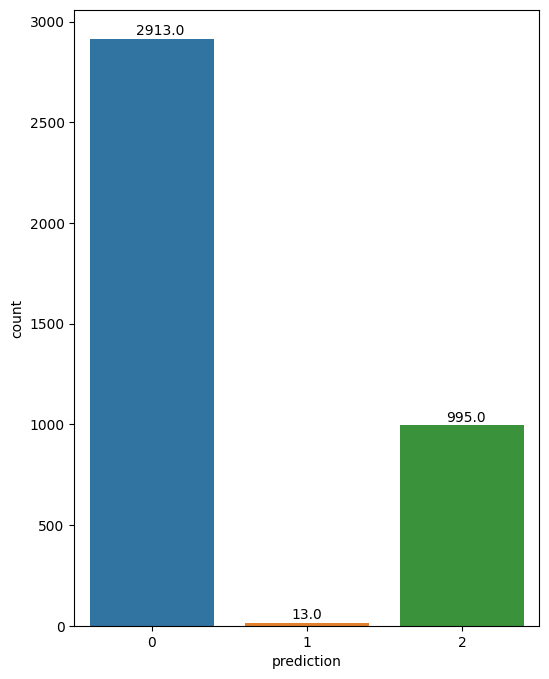

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=combined_result_df)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

We plot the recency, frequency, and monetary values of each cluster in a box plot, in order to better understand the prediction result.

<AxesSubplot: xlabel='prediction', ylabel='Monetary'>

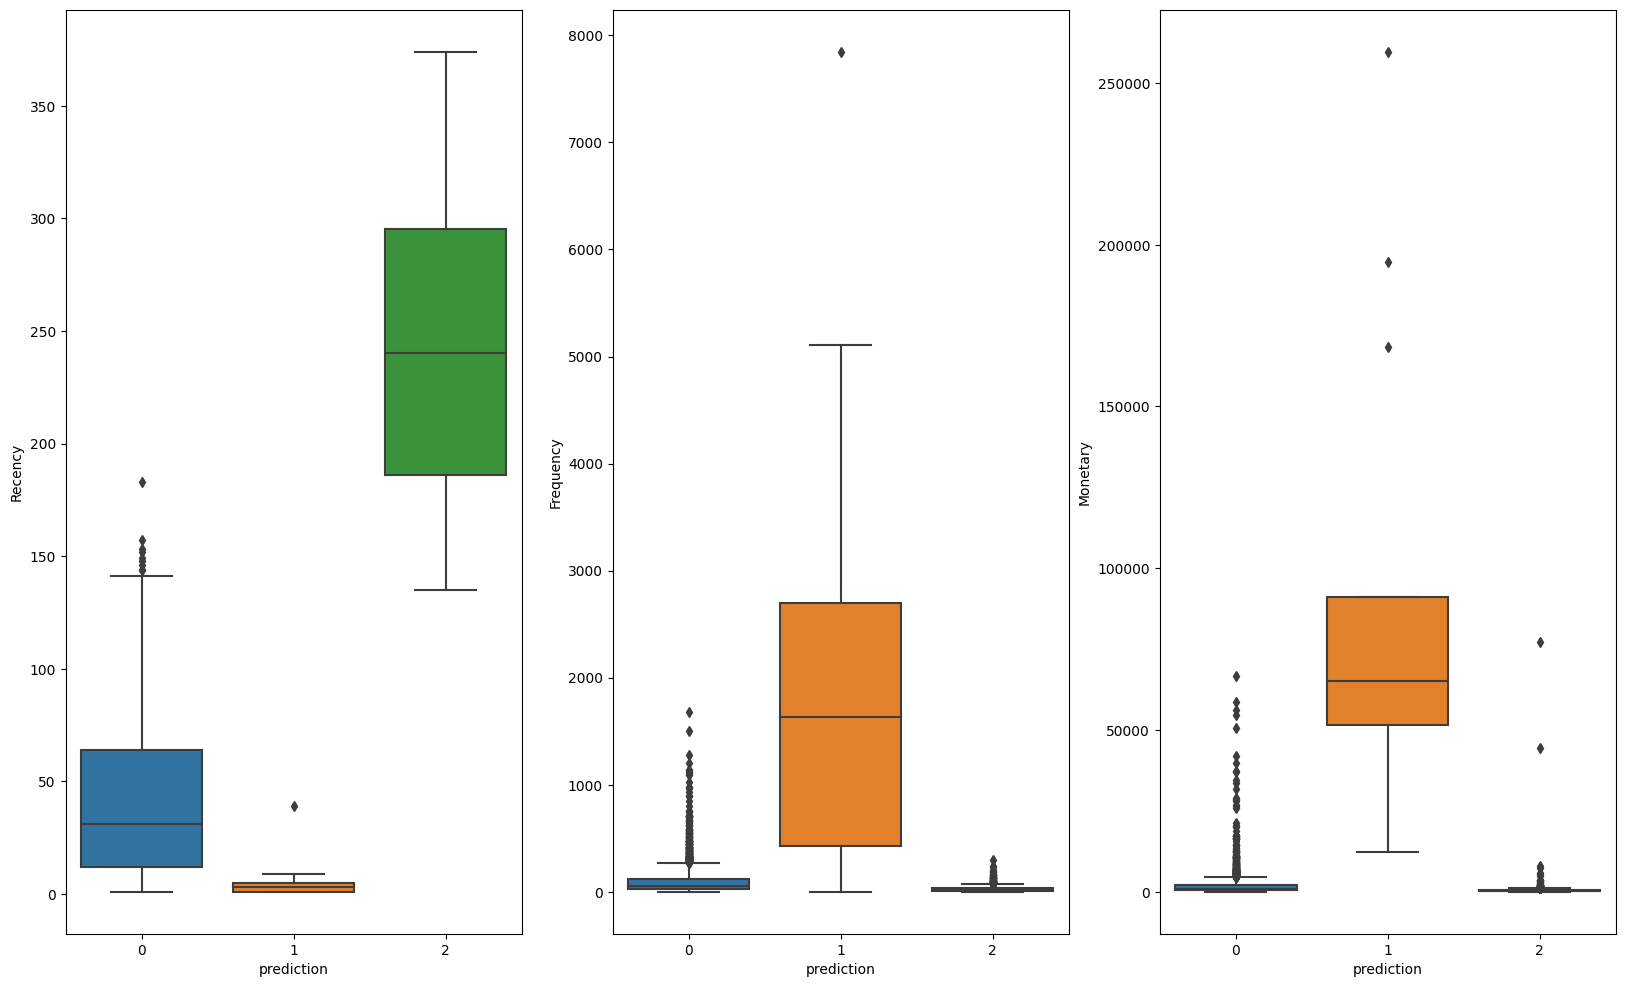

In [36]:
analysis_df = combined_result.toPandas()
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='Recency', data=analysis_df, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=analysis_df, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=analysis_df, ax=ax[2])

The boxplots of cluster values corresponds to each feature is shown. Using these boxplots we can identify the possible outliers corresponds to each feature.

# Visualizing Clusters
Visualizing the clusters by combining two features as a 2D plot will give a clear view about the grouping strategies of datapoints. 

<AxesSubplot: xlabel='Monetary', ylabel='Frequency'>

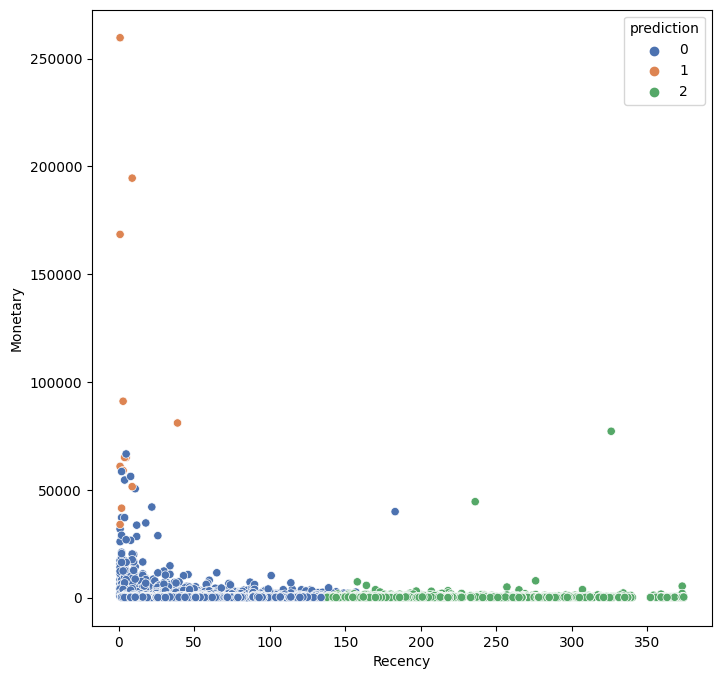

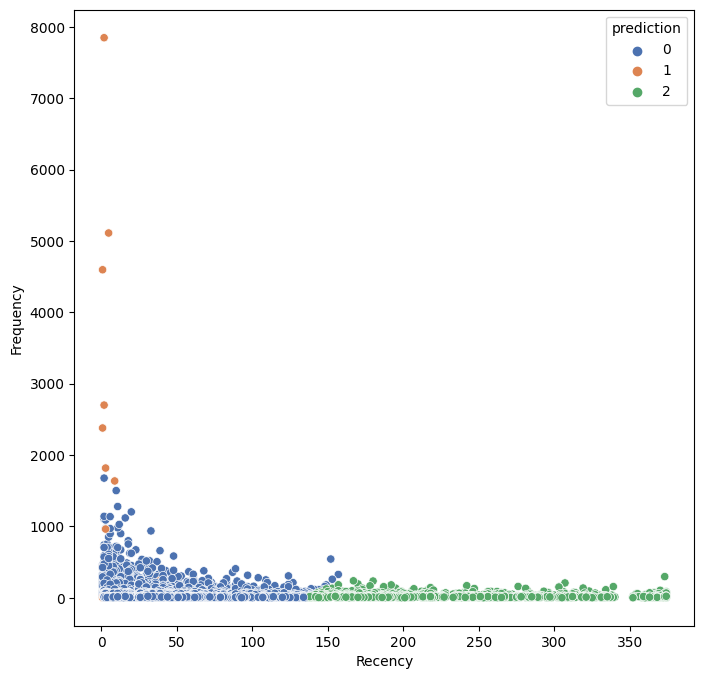

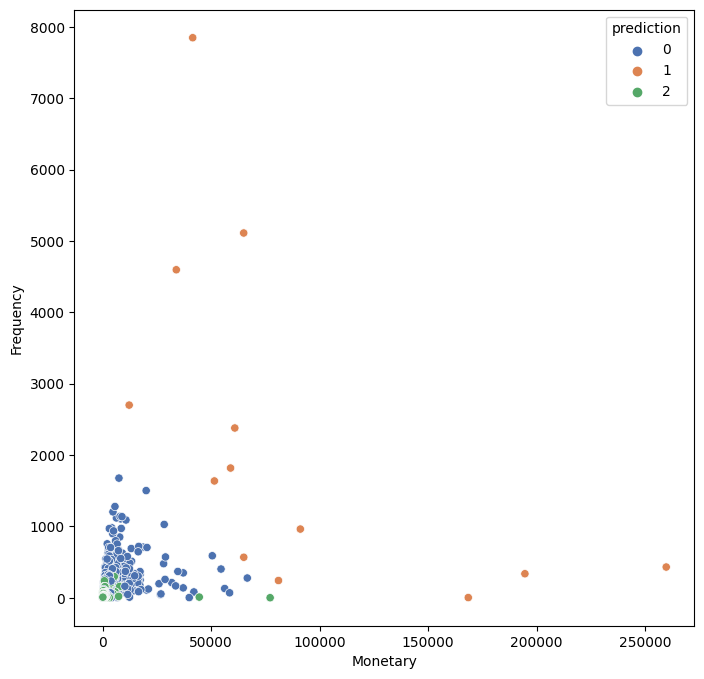

In [37]:
selected_result_df = combined_result_df#.query('Monetary < 100000').query('Frequency < 3000')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# 3D Visualization of clustering

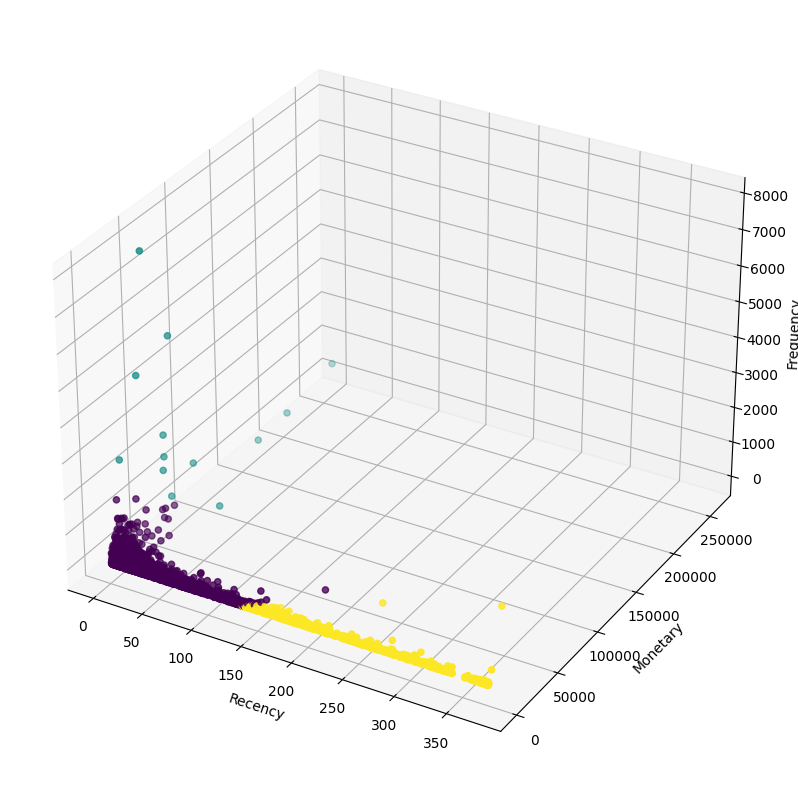

In [38]:

from mpl_toolkits.mplot3d import axes3d, Axes3D
threedee = plt.figure(figsize=(12,10))
ax = plt.axes(projection ="3d")
ax.scatter3D(selected_result_df.Recency, selected_result_df.Monetary, selected_result_df.Frequency, c=selected_result_df.prediction)
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')
plt.show()

3D Visualization can give a good insight about how datagrouping is done corresponds to each feature in a single plot

In [39]:
spark.stop()